# Import Libraries

In [35]:
from dash import Dash, html, dcc, callback, Output, Input, State
import dash_bootstrap_components as dbc
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash.exceptions import PreventUpdate
import plotly as py

import pandas as pd
import numpy as np

import json

# Initialize App 

In [7]:
app = Dash(
    __name__,
    external_stylesheets=[
        dbc.themes.BOOTSTRAP,
        dbc.icons.FONT_AWESOME
    ]
)

# Load Data

In [8]:
athlete_events_df = pd.read_csv("./assets/athlete_events.csv")
noc_regions_df = pd.read_csv("./assets/noc_regions.csv")

# Total Medal Count by Height and Weight, grouped by Sport (Heatmap Figure)

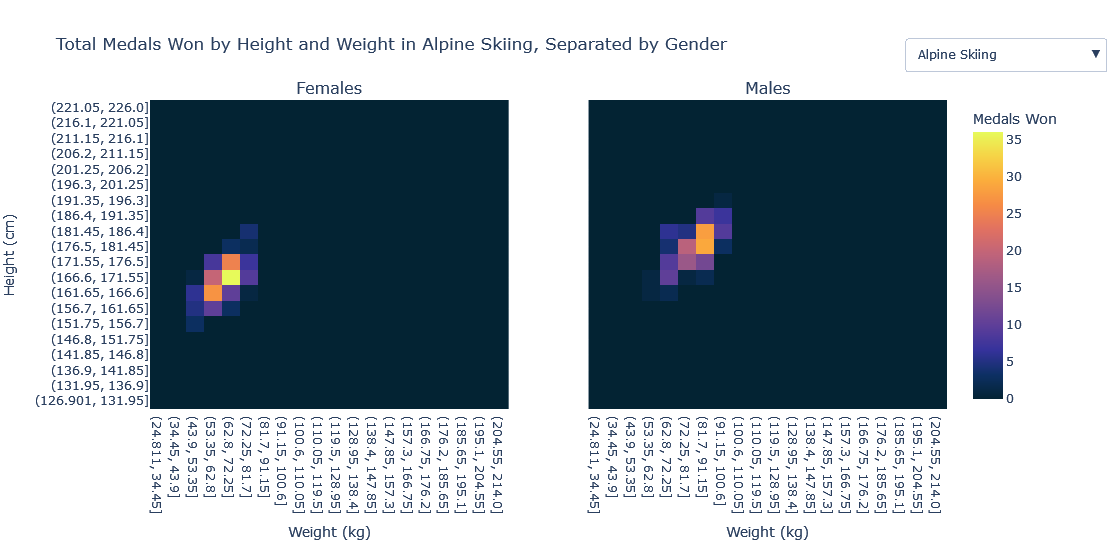

In [9]:
# Create bins for height and weight
height_weight_medal_df = athlete_events_df.copy()
height_weight_medal_df = height_weight_medal_df.dropna(subset=["Height", "Weight"])
height_weight_medal_df["Height Bin"] = pd.cut(height_weight_medal_df["Height"], bins=20)
height_weight_medal_df["Weight Bin"] = pd.cut(height_weight_medal_df["Weight"], bins=20)

# Group by sports, separated by sex
height_weight_medal_df = height_weight_medal_df.groupby(["Sport", "Sex", "Height Bin", "Weight Bin"], observed=False)["Medal"].count().reset_index(name="Medal Count")

# Create pivot tables for each sport and sex
sports_df_list = {}
for (col, sport) in height_weight_medal_df.groupby("Sport"):
    sports_df_list[col] = {}
    for (c, sex) in sport.groupby("Sex"):
        sports_df_list[col][c] = pd.pivot_table(sex, index="Height Bin", columns="Weight Bin", values="Medal Count", observed=False).fillna(0)
for sport in sports_df_list.keys():
    for sex in sports_df_list[sport]:
        sports_df_list[sport][sex].columns = sports_df_list[sport][sex].columns.astype(str)
        sports_df_list[sport][sex].index = sports_df_list[sport][sex].index.astype(str)
        
# Create heatmap subplot figure
heatmap_fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=("Females", "Males"),
    shared_yaxes=True
)

# Starting heatmap
heatmap_fig.add_trace(
    go.Heatmap(
        x=sports_df_list["Alpine Skiing"]["F"].columns,
        y=sports_df_list["Alpine Skiing"]["F"].index,
        z=sports_df_list["Alpine Skiing"]["F"].values,
        visible=True,
        hovertemplate=
            "<b>Height Bin:</b> %{y}cm<br>" +
            "<b>Weight Bin:</b> %{x}kg<br>" +
            "<b>Total Medals Won:</b> %{z}",
        name="",
        coloraxis="coloraxis"
    ),
    row=1,
    col=1
)
heatmap_fig.add_trace(
    go.Heatmap(
        x=sports_df_list["Alpine Skiing"]["M"].columns,
        y=sports_df_list["Alpine Skiing"]["M"].index,
        z=sports_df_list["Alpine Skiing"]["M"].values,
        visible=True,
        hovertemplate=
            "<b>Height Bin:</b> %{y}cm<br>" +
            "<b>Weight Bin:</b> %{x}kg<br>" +
            "<b>Total Medals Won:</b> %{z}",
        name="",
        # colorscale="coloraxis"
        coloraxis="coloraxis"
    ),
    row=1,
    col=2
)
heatmap_fig.update_layout(
    title="Total Medals Won by Height and Weight in Alpine Skiing, Separated by Gender"
)

# Add heatmap traces for each sport
for i, sport in enumerate(sports_df_list.keys()):
    for j, sex in enumerate(sports_df_list[sport]):
        heatmap_fig.add_trace(
            go.Heatmap(
                x=sports_df_list[sport][sex].columns,
                y=sports_df_list[sport][sex].index,
                z=sports_df_list[sport][sex].values,
                visible=False,
                hovertemplate=
                    "<b>Height Bin:</b> %{y}cm<br>" +
                    "<b>Weight Bin:</b> %{x}kg<br>" +
                    "<b>Total Medals Won:</b> %{z}",
                name="",
                coloraxis="coloraxis"
            ),
            row=1,
            col=j + 1
        )

# Create dropdown option for each sport
sports_options = []
for i, key in enumerate(sports_df_list.keys()):
    visible_list = [False] * (len(sports_df_list.keys()) + 2) * 2
    visible_list[i * 2 + 2] = True
    visible_list[i * 2 + 3] = True
    sports_options.append(dict(
        label=key,
        method="update",
        args=[
            {"visible":visible_list},
            {"title":f"Total Medals Won by Height and Weight in {key}, Separated by Gender"}
        ]
    ))
    
heatmap_fig.update_layout(
    width=1000,
    height=550,
    autosize=False,
    coloraxis=dict(
        colorscale="thermal",
        colorbar=dict(
            title="Medals Won"
        )
    ),
    updatemenus=[dict(
        active=0,
        buttons=sports_options,
        x=1.2,
        y=1.2
    )]
)

heatmap_fig.update_xaxes(
    title_text="Weight (kg)",
    row=1,
    col=1
)
heatmap_fig.update_xaxes(
    title_text="Weight (kg)",
    row=1,
    col=2
)
heatmap_fig.update_yaxes(
    title_text="Height (cm)",
    row=1,
    col=1
)
    
heatmap_fig.show()

# Interactive Map (Choropleth Figure)

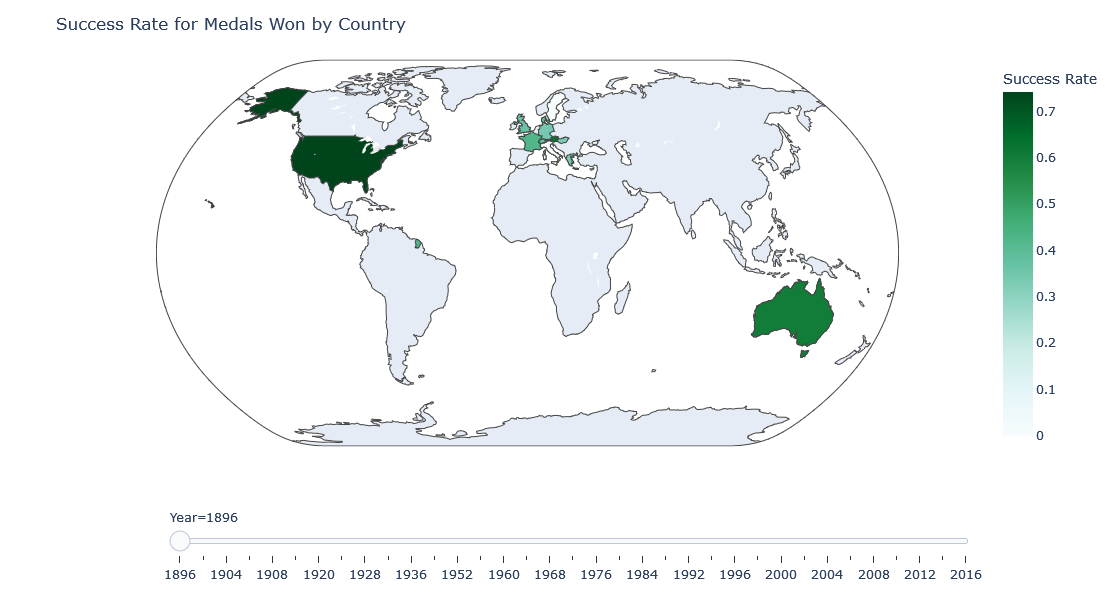

In [123]:
medals_won_df = athlete_events_df.drop_duplicates(subset=["NOC", "Games", "Year", "Season", "City", "Sport", "Event"])
medals_won_df = athlete_events_df.merge(noc_regions_df, on="NOC", how="left")
medals_won_df = medals_won_df.groupby(["Year", "region"])["Medal"].count().reset_index(name="Won")
medals_won_df

medals_attempted_df = athlete_events_df.drop_duplicates(subset=["NOC", "Games", "Year", "Season", "City", "Sport", "Event"])
medals_attempted_df = athlete_events_df.merge(noc_regions_df, on="NOC", how="left")
medals_attempted_df["Medal"] = medals_attempted_df["Medal"].fillna("None")
medals_attempted_df = medals_attempted_df.groupby(["Year", "region"])["Medal"].count().reset_index(name="Attempted")

success_rate_df = medals_won_df.merge(medals_attempted_df, on=["Year", "region"], how="left")
success_rate_df["Success Rate"] = success_rate_df["Won"] / success_rate_df["Attempted"]

success_rate_df

# Choropleth figure
choropleth_fig = px.choropleth(
    success_rate_df,
    animation_frame='Year',
    animation_group='Success Rate',
    title="Success Rate for Medals Won by Country",
    locations="region",
    locationmode="country names",
    hover_name="region",
    hover_data={
        'region':False,
        'Year':False,
        'Success Rate':':.2f%'
    },
    
    # dict(
    #     region=False,
    #     Year=False,
    #     Success Rate=":.2f%"
    # ),
    color="Success Rate",
    color_continuous_scale="BuGn",
    projection="natural earth"
)
choropleth_fig["layout"].pop("updatemenus")
choropleth_fig.update_layout(
    margin=dict(l=80, r=80, t=60, b=60),
    width=800,
    height=600
)
choropleth_fig.show()
# print(choropleth_fig.layout.sliders[0].active)
# print(choropleth_fig.layout.sliders[0].steps[choropleth_fig.layout.sliders[0].active].label)

# Country Data Drill-In

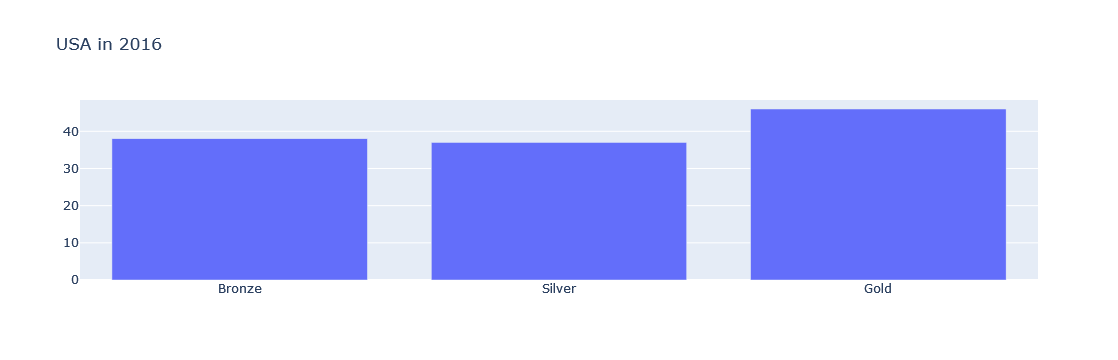

In [115]:
# Group total medals won by NOC, removing duplicates from individuals winning medals from team sports to only count one medal
medals_distribution_df = athlete_events_df.dropna(subset=["Medal"])
medals_distribution_df = medals_distribution_df.drop_duplicates(subset=["NOC", "Games", "Year", "Season", "City", "Sport", "Event", "Medal"])
medals_distribution_df = medals_distribution_df.merge(noc_regions_df, on="NOC", how="left")
medals_distribution_df = medals_distribution_df.groupby(["Year", "region", "Medal"])["Medal"].count().unstack(fill_value=0).stack().reset_index(name="Medal Count")

color_seq = ["#CD7F32", "#C0C0C0", "#D4AF37"]

# List of medals won by NOC
year_df_list = {col:year for (col, year) in medals_distribution_df.groupby("Year")}

# Bar figure
medals_fig_list = {}
for year, df in year_df_list.items():
    for (country, row) in df.groupby('region'):
        if year not in medals_fig_list:
            medals_fig_list[year] = {}
        medals_fig_list[year][country] = go.Figure(
            data=go.Bar(
                x=row["Medal"],
                y=row["Medal Count"],
            )
        )
        medals_fig_list[year][country].update_layout(
            title=f"{country} in {year}",
            xaxis={'categoryorder':'array', 'categoryarray':["Bronze", "Silver", "Gold"]}
        )

medals_fig_list[2016]['USA']

# Athlete Performance Over First 4 Games (Sankey Diagram)

In [237]:
FIRST_N_GAMES = 4
performance_df = athlete_events_df.copy()
performance_df = performance_df.dropna(subset=["Name", "Year"])
# performance_df["Medal"] = performance_df["Medal"].fillna("None")

# performance_df = performance_df.groupby(["Name", "Year"])["Medal"].count().reset_index(name="Medal Count")
# performance_df = performance_df.groupby(["Name"]).filter(lambda x: x["Year"].nunique() > FIRST_N_GAMES)
# performance_df["Appearance"] = performance_df.sort_values(by="Year").groupby("Name")["Year"].rank(method="first").astype(int)
# performance_df = performance_df[performance_df["Appearance"] <= FIRST_N_GAMES]
# performance_df = performance_df.groupby(["Name", "Appearance"])["Medal Count"].sum().reset_index(name="Medal Count")
# performance_df["Source"] = performance_df.apply(lambda x: x["Appearance"] - 1, axis=1)

# performance_df = performance_df.groupby(["Name", "Year", "Medal"])["Medal"].count().reset_index(name="Medal Count")
# performance_df = performance_df.groupby(["Name"]).filter(lambda x: x["Year"].nunique() > FIRST_N_GAMES)
# performance_df["Appearance"] = performance_df.sort_values(by="Year").groupby("Name")["Year"].rank(method="first").astype(int)
# performance_df = performance_df[performance_df["Appearance"] <= FIRST_N_GAMES]
# performance_df = performance_df.groupby(["Name", "Appearance", "Medal"])["Medal Count"].sum().reset_index(name="Medal Count")
# performance_df["Label"] = performance_df.apply(lambda x: f"{x['Medal']} Year {x['Appearance']}", axis=1)

performance_df = performance_df.groupby(["Name", "Year", "Medal"])["Medal"].count().reset_index(name="Medal Count")
performance_df = performance_df.groupby(["Name"]).filter(lambda x: x["Year"].nunique() > FIRST_N_GAMES)
performance_df["Appearance"] = performance_df.sort_values(by="Year").groupby("Name")["Year"].rank(method="first").astype(int)
performance_df = performance_df[performance_df["Appearance"] <= FIRST_N_GAMES]
# performance_df = performance_df.groupby(["Name", "Appearance", "Medal"])["Medal Count"].sum().reset_index(name="Medal Count")
# performance_df["Label"] = performance_df.apply(lambda x: f"{x['Medal']} Year {x['Appearance']}", axis=1)
performance_df = performance_df.groupby(["Medal", "Appearance"])["Medal Count"].sum().reset_index(name="Medal Count")
performance_df["Source"] = performance_df["Appearance"] - 1
performance_df["Target"] = performance_df.apply(lambda x: x["Source"] + 1, axis=1)
color_map = {"Bronze":"#CD7F32", "Silver":"#C0C0C0", "Gold":"#D4AF37"}
performance_df["Color"] = performance_df.apply(lambda x: color_map[x["Medal"]], axis=1)
order_map = {"Bronze":0, "Silver":1, "Gold":2}
performance_df = performance_df.sort_values(by="Medal", key=lambda x: x.map(order_map))
# performance_df

# medal_map = {"None":0, "Bronze":1, "Silver":2, "Gold":3}
# performance_df["Source"] = performance_df.apply(lambda x: medal_map[x['Medal']] + x['Appearance'] * len(medal_map) - len(medal_map), axis=1)
# performance_df["Link"] = performance_df.apply(lambda x: 
# performance_df["Link"] = performance_df.apply(lambda x: medal_map[x["Medal"]] + x["Appearance"] * len(medal_map) if x["Appearance"] < FIRST_N_GAMES else np.nan, axis=1)
# performance_df[performance_df["Source"] == 0]
performance_df

,Medal,Appearance,Medal Count,Source,Target,Color
0,Bronze,1,12,0,1,#CD7F32
1,Bronze,2,22,1,2,#CD7F32
2,Bronze,3,10,2,3,#CD7F32
3,Bronze,4,9,3,4,#CD7F32
8,Silver,1,26,0,1,#C0C0C0
9,Silver,2,12,1,2,#C0C0C0
10,Silver,3,17,2,3,#C0C0C0
11,Silver,4,20,3,4,#C0C0C0
4,Gold,1,22,0,1,#D4AF37
5,Gold,2,31,1,2,#D4AF37


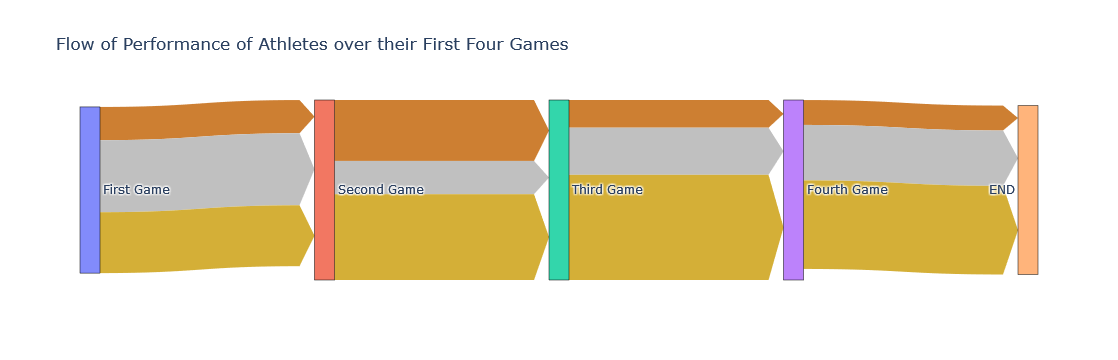

In [229]:
# import urllib, json

# url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
# response = urllib.request.urlopen(url)
# data = json.loads(response.read())

# # override gray link colors with 'source' colors
# opacity = 0.4
# # change 'magenta' to its 'rgba' value to add opacity
# data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
# data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
#                                     for src in data['data'][0]['link']['source']]

# fig = go.Figure(data=[go.Sankey(
#     valueformat = ".0f",
#     valuesuffix = "TWh",
#     # Define nodes
#     node = dict(
#       pad = 15,
#       thickness = 15,
#       line = dict(color = "black", width = 0.5),
#       label =  data['data'][0]['node']['label'],
#       color =  data['data'][0]['node']['color']
#     ),
#     # Add links
#     link = dict(
#       source =  data['data'][0]['link']['source'],
#       target =  data['data'][0]['link']['target'],
#       value =  data['data'][0]['link']['value'],
#       label =  data['data'][0]['link']['label'],
#       color =  data['data'][0]['link']['color']
# ))])

# fig.update_layout(title_text="Energy forecast for 2050<br>Source: Department of Energy & Climate Change, Tom Counsell via <a href='https://bost.ocks.org/mike/sankey/'>Mike Bostock</a>",
#                   font_size=10)
# fig.show()
# data['data'][0]['node']['label']
# data['data'][0]['link']['source']
# data['data'][0]['link']['target']
# data['data'][0]['link']['value']

# labels = []
# for i in range(FIRST_N_GAMES):
#     labels.append(f"None Year {i + 1}")
#     labels.append(f"Bronze Year {i + 1}")
#     labels.append(f"Silver Year {i + 1}")
#     labels.append(f"Gold Year {i + 1}")
labels = ["First Game", "Second Game", "Third Game", "Fourth Game", "END"]
# colors = ["red"] * len(performance_df["Source"])
# colors[0] = "blue"
# colors[1] = "green"
# colors = ["#CD7F32", "#CD7F32", "#CD7F32", "#CD7F32",  "#C0C0C0", "#C0C0C0", "#C0C0C0","#C0C0C0", "#D4AF37", "#D4AF37", "#D4AF37",  "#D4AF37", ]
# for i in range(FIRST_N_GAMES):
    # colors.append("#CD7F32")
    # colors.append("#C0C0C0")
    # colors.append("#D4AF37")
    # colors.append("blue")

# colors = ["#CD7F32", "#C0C0C0", "#D4AF37", "#FFFFFF"] * len(medal_map)

sankey_fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels
    ),
    link = dict(
        arrowlen=15,
        source = performance_df["Source"],
        target = performance_df["Target"],
        value = performance_df["Medal Count"],
        color = performance_df["Color"]
    )
)])
# print(performance_df["Label"])

sankey_fig.update_layout(title_text="Flow of Performance of Athletes over their First Four Games")
sankey_fig.show()

# Dash Layout

In [ ]:
choropleth_fig.update_layout(clickmode='event+select')

app.layout = html.Div([
    dcc.Graph(
        id="choropleth",
        figure=choropleth_fig
    ),
    dcc.Graph(
        id="heatmap",
        figure=heatmap_fig
    ),
    dbc.Modal([
        dbc.ModalHeader(dbc.ModalTitle(id="modal-text", children=[
            "Placeholder"
        ])),
        dcc.Graph(
            id="drill-in",
            figure=medals_fig_list["USA"]
        )],
        id="modal-sm",
        size="sm",
        is_open=False,
    )
])

@callback([
        Output("modal-text", "children"),
        Output("modal-sm", "is_open"),
        Output("drill-in", "figure")
    ],
    [Input("choropleth", "clickData")],
    [
        State("modal-sm", "is_open"),
        State("drill-in", "figure")
    ]
)
def update_modal(clickData, is_open, figure):
    if clickData is None:
        raise PreventUpdate
    if is_open is None:
        raise PreventUpdate
    if figure is None:
        raise PreventUpdate
        
    if clickData:
        print(medals_fig_list[clickData["points"][0]["hovertext"]])
        return clickData["points"][0]["location"], not is_open, medals_fig_list[clickData["points"][0]["hovertext"]]
    return None, is_open, None

# Run Dash App

In [ ]:
app.run_server(debug=True)